# Create explanatory variables

In [1]:
# =============================================================================
# LOAD PROCESSED BCH DATAFRAME FROM PARQUET
# =============================================================================
import pandas as pd

# Path to processed data
input_path = 'data/bchusdt_1m_processed.parquet'

# Load into DataFrame
df = pd.read_parquet(input_path)

# Quick check
display(df.head()) 

,open_time,open,high,low,close,volume,future_4h_max_close,future_4h_max_ratio,spike_flag
0,2019-11-28 10:00:00,220.08,224.60,212.02,224.60,7.23587,224.59,0.999955,0
1,2019-11-28 10:01:00,224.60,224.60,224.59,224.59,1.75804,223.89,0.996883,0
2,2019-11-28 10:02:00,224.59,224.60,218.50,218.67,12.24359,223.89,1.023872,0
3,2019-11-28 10:03:00,219.00,222.53,219.00,219.06,14.87814,223.89,1.022049,0
4,2019-11-28 10:04:00,220.00,223.89,218.52,223.89,61.79853,219.30,0.979499,0


In [ ]:
# =============================================================================
# CALCULATE RSI, MACD, SMA RATIO, BOLLINGER WIDTH, ROC FOR MULTIPLE WINDOWS
# =============================================================================
import ta

# RSI (prediktív célú, csak múlt adatokkal)
df['rsi_14_backward'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()

# MACD diff (klasszikus: 12/26/9)
macd_calc       = ta.trend.MACD(close=df['close'])
df['macd_diff'] = macd_calc.macd_diff()

# SMA-ratio: ár / mozgóátlag (trend)
df['sma_14']        = ta.trend.SMAIndicator(close=df['close'], window=14).sma_indicator()
df['sma_140']       = ta.trend.SMAIndicator(close=df['close'], window=140).sma_indicator()
df['sma_ratio_14']  = df['close'] / df['sma_14']
df['sma_ratio_140'] = df['close'] / df['sma_140']

# Bollinger Band width (volatilitás)
bb_14              = ta.volatility.BollingerBands(close=df['close'], window=14)
bb_140             = ta.volatility.BollingerBands(close=df['close'], window=140)
df['bb_width_14']  = bb_14.bollinger_wband()
df['bb_width_140'] = bb_140.bollinger_wband()

# Rate of Change (momentum, %)
df['roc_14']  = ta.momentum.ROCIndicator(close=df['close'], window=14).roc()
df['roc_140'] = ta.momentum.ROCIndicator(close=df['close'], window=140).roc()

# =============================================================================
# FINAL FEATURES + TARGET AND MISSING ROWS
# =============================================================================
features = [
    'rsi_14_backward',
    'macd_diff',
    'sma_ratio_14', 'sma_ratio_140',
    'bb_width_14', 'bb_width_140',
    'roc_14', 'roc_140'
]

target = 'spike_flag'

# Final DataFrame for modeling
df_model = df[features + [target]].dropna()

# Quick check
print("df_model shape:", df_model.shape)
display(df_model.head())

df_model shape: (3099874, 9)


,rsi_14_backward,macd_diff,sma_ratio_14,sma_ratio_140,bb_width_14,bb_width_140,roc_14,roc_140,spike_flag
140,33.241235,-0.037620,0.998917,0.996992,0.277045,1.398076,-0.123689,-2.929653,0
141,33.241235,-0.036248,0.999005,0.997206,0.297760,1.059572,-0.123689,-2.925331,0
142,33.241235,-0.032632,0.999051,0.997227,0.313401,1.063745,-0.064173,-0.297252,0
143,33.241235,-0.027726,0.999142,0.997261,0.325452,1.065708,-0.128264,-0.474756,0
144,38.572095,-0.017738,0.999532,0.997770,0.326193,0.687343,-0.096198,-2.590558,0


In [5]:
# =============================================================================
# LOGISTIC REGRESSION: FULL MODEL
# =============================================================================
import statsmodels.api as sm

# Változók listája
features = [
    'rsi_14_backward',
    'macd_diff',
    'sma_ratio_14', 'sma_ratio_140',
    'bb_width_14', 'bb_width_140',
    'roc_14', 'roc_140'
]
target = 'spike_flag'

# Tisztított DataFrame (csak teljes sorok)
df_logit = df[features + [target]].dropna()

# Magyarázó és célváltozó
X_full = df_logit[features]
y      = df_logit[target]

# Intercept hozzáadása
X_full = sm.add_constant(X_full)

# Modell illesztése
logit_model = sm.Logit(y, X_full)
result_full = logit_model.fit()

# Teljes eredmény
# print("===== FULL MODEL SUMMARY =====")
# display(result_full.summary().tables[1])

# =============================================================================
# VARIABLE SELECTION: KEEP ONLY p < 0.01
# =============================================================================

# p-értékek kivonása a modellből
p_values = result_full.pvalues.drop('const')  # konstans kivétele

# Változók kiválasztása p < 0.01 szerint
significant_vars = p_values[p_values < 0.01].index.tolist()

# print("\nSignificant variables (p < 0.01):", significant_vars)

# =============================================================================
# FINAL MODEL WITH SIGNIFICANT VARIABLES ONLY
# =============================================================================

# Új adatkeret csak a kiválasztott változókkal
X_final = df_logit[significant_vars]
X_final = sm.add_constant(X_final)

# Új modell illesztése
final_model = sm.Logit(y, X_final).fit()

# Final model summary
print("\n===== FINAL MODEL (p < 0.01) =====")
display(final_model.summary().tables[1])


Optimization terminated successfully.
         Current function value: 0.300825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300826
         Iterations 7

===== FINAL MODEL (p < 0.01) =====


,coef,std err,z,P>|z|,[0.025,0.975]
const,12.5285,1.136,11.029,0.000,10.302,14.755
rsi_14_backward,0.0071,0.000,27.111,0.000,0.007,0.008
sma_ratio_14,-15.9007,1.140,-13.943,0.000,-18.136,-13.666
bb_width_14,0.6123,0.003,184.742,0.000,0.606,0.619
bb_width_140,0.1798,0.001,170.321,0.000,0.178,0.182
roc_14,-0.0472,0.006,-7.643,0.000,-0.059,-0.035
roc_140,0.0102,0.001,9.644,0.000,0.008,0.012


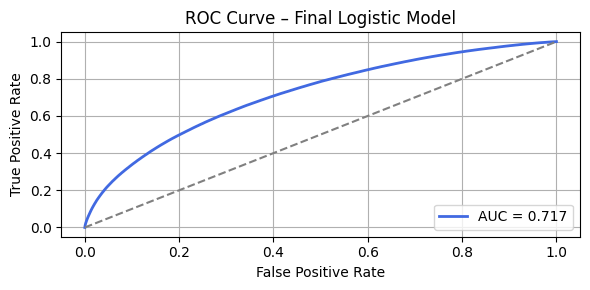

In [9]:
# =============================================================================
# EVALUATE FINAL MODEL WITH ROC CURVE AND AUC SCORE
# =============================================================================
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prediktált valószínűségek a spike eseményre
y_pred_proba_final = final_model.predict(X_final)

# Valódi címkék (célváltozó)
y_true_final = y

# ROC és AUC számítás
fpr, tpr, thresholds = roc_curve(y_true_final, y_pred_proba_final)
auc_score = roc_auc_score(y_true_final, y_pred_proba_final)

# Plot
plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='royalblue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Final Logistic Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test

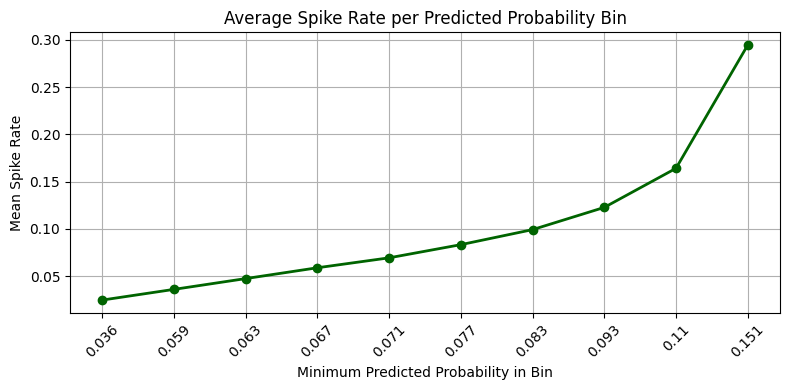

In [5]:
# =============================================================================
# CREATE CALIBRATION TABLE WITH PREDICTED PROBABILITIES
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt

# Táblázat valódi címkékkel és prediktált valószínűségekkel
calibration_df = pd.DataFrame({
    'spike_flag': y_true_final,
    'predicted_proba': y_pred_proba_final
})

# Először kvantilis binelés kategória objektummal (megtartjuk az intervalokat)
bin_intervals = pd.qcut(calibration_df['predicted_proba'], q=10)

# Minimum értékek (left határok)
bin_mins = [round(interval.left, 3) for interval in bin_intervals.cat.categories]

# Bin-label-ek ("Bin 1" ... "Bin 10")
labels = [f'Bin {i+1}' for i in range(10)]

# Ugyanazokat az intervallumokat használva - label hozzárendelés
calibration_df['prob_bin'] = pd.qcut(
    calibration_df['predicted_proba'],
    q=10,
    labels=labels
)

# Átlag spike arány bin-enként
bin_means = calibration_df.groupby('prob_bin', observed=True)['spike_flag'].mean().reset_index()

# =============================================================================
# PLOT CALIBRATION CURVE – X-tengelyen a bin minimum értékek
# =============================================================================
plt.figure(figsize=(8, 4))
plt.plot(labels, bin_means['spike_flag'], marker='o', linewidth=2, color='darkgreen')

# X-tengelyre bin min értékek beállítása (de a csoportosítás marad "Bin X")
plt.xticks(ticks=labels, labels=bin_mins, rotation=45)

plt.title('Average Spike Rate per Predicted Probability Bin')
plt.xlabel('Minimum Predicted Probability in Bin')
plt.ylabel('Mean Spike Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# =============================================================================
# Slim save, because the standard process save the whole train sample as well
# =============================================================================

import os
import pickle  # csak fallbackhoz
os.makedirs('model', exist_ok=True)
model_path = 'model/final_logit_model.pkl'

# Opcionális: pár stat cache-elődik, hogy remove_data után is elérhető legyen
try:
    _ = final_model.summary()
except Exception:
    pass

# Elsődleges, kicsi fájl: a tanítóadatok eltávolításával ment
try:
    final_model.save(model_path, remove_data=True)
except Exception:
    # Fallback, ha a fenti nem elérhető a te statsmodels verziódban
    try:
        final_model.remove_data()
    except Exception:
        pass
    with open(model_path, 'wb') as f:
        pickle.dump(final_model, f)

print(f"✅ Slim model saved to: {model_path}")

✅ Slim model saved to: model/final_logit_model.pkl


In [ ]:
# =============================================================================
# SAVE TRAIN SAMPLE WITH PREDICTED PROBABILITIES
# =============================================================================
import os
os.makedirs('data', exist_ok=True)

train_with_predictions = df_logit.copy()
train_with_predictions['predicted_proba'] = y_pred_proba_final
train_with_predictions['spike_flag'] = y_true_final.values

train_output_path = 'data/train_with_predictions.parquet'
train_with_predictions.to_parquet(train_output_path)

print(f'✅ Train sample with predictions saved to: {train_output_path}')
display(train_with_predictions.head())
